In [1]:
import scanpy as sc
import pandas as pd
from pathlib import Path
import anndata as ad
import numpy as np
import os
import scvi

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

DPI = 300
FONTSIZE = 20  # 42

sc.settings.set_figure_params(
    scanpy=True, dpi=100, transparent=True, vector_friendly=True, dpi_save=DPI
)
from matplotlib import rcParams

rcParams["pdf.fonttype"] = 42

Global seed set to 0


In [2]:
DIR2SAVE = Path(
    "/data/BCI-CRC/nasrine/data/CRC/Metastatic_CRC_LM_dataset/subpopulations/Myeloid/scvi_latent20/alternative_version"
)
DIR2SAVE.mkdir(parents=True, exist_ok=True)

In [3]:
FIG2SAVE = DIR2SAVE.joinpath("figures/")
FIG2SAVE.mkdir(parents=True, exist_ok=True)
# set the global variable: sc.settings.figdir to save all plots
sc.settings.figdir = FIG2SAVE

In [4]:
adata_full = sc.read_h5ad(
    DIR2SAVE.joinpath(
        "Multiome_Che_Wu_CRC_LM_integrated_scvi_hvg_Myeloid_clustering_annotations.h5ad"
    )
)

In [5]:
DIR2SAVE

PosixPath('/data/BCI-CRC/nasrine/data/CRC/Metastatic_CRC_LM_dataset/subpopulations/Myeloid/scvi_latent20/alternative_version')

In [6]:
adata = adata_full[adata_full.obs.Annotation_scVI_detailed == "DC"].copy()

In [7]:
adata

AnnData object with n_obs × n_vars = 2017 × 2000
    obs: 'Patient', 'Sample', 'Cell_type', 'Cell_subtype', 'Tissue', 'Therapy', 'doublet_score', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo', 'cell_source', 'Annotation_scVI', 'S_score', 'G2M_score', 'phase', 'cell_cycle_diff', '_scvi_batch', '_scvi_labels', 'leiden_scVI', 'leiden_scVI_r1.5', 'leiden_scVI_r1', 'Annotation_scVI_detailed'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'Annotation_scVI_detailed_colors', 'Cell_subtype_colors', 'Cell_type_colors', 'Therapy_colors', 'Tissue_colors', '_scvi_manager_uuid', '_scvi_uuid', 'cell_source_colors', 'dendrogram_leiden_scVI', 'hvg', 'leiden', 'leiden_scVI_colors', 'leiden_scVI_r1.5_colors', 'leiden_scVI_r1_colors', 'log1p', 'neighbors', 'pca', 'phase_colors', 'rank_genes_wilcoxon', 'umap'
    obsm: 'X_pca', 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs', '_scvi_extr

### Leiden clustering

In [8]:
adata.uns["neighbors"]

OverloadedDict, wrapping:
	{'connectivities_key': 'connectivities', 'distances_key': 'distances', 'params': {'method': 'umap', 'metric': 'euclidean', 'n_neighbors': 15, 'n_pcs': 20, 'random_state': 7, 'use_rep': 'X_scVI'}}
With overloaded keys:
	['connectivities', 'distances'].

In [9]:
from collections import Counter


def clustering_leiden_resolution(adata2test, res_range):
    """
    Performs hyperparameter search for resolution in leiden clustering
    :param adata2test: AnnData frame
    :param res_range: range of values to evaluate: i.e. np.arange(0.1, 1.5, 0.05)
    """
    resolution_dict = {r: None for r in res_range}
    # vary resolution parameter and see which nb of clusters occurs more frequently
    for r in res_range:
        # load adata
        adata = adata2test.copy()
        sc.tl.leiden(adata, resolution=r, random_state=7)
        # store nb of clusters for that resolution
        resolution_dict[r] = len(set(adata.obs["leiden"]))

    # plot figure: nb clusters in fct of resolution param
    fig, ax = plt.subplots(
        nrows=1, ncols=1, sharey=False, sharex=False, dpi=DPI, figsize=(5, 4.5)
    )
    plt.scatter(resolution_dict.keys(), resolution_dict.values())
    ax.set_xlabel("Resolution")
    ax.set_ylabel("Number of clusters")
    ax.tick_params(axis="both", which="major", labelsize=FONTSIZE - 10)
    plt.show()

    # display nb of times each number of clusters occurs
    print("Frequency of NB clusters")
    print(Counter(list(resolution_dict.values())))

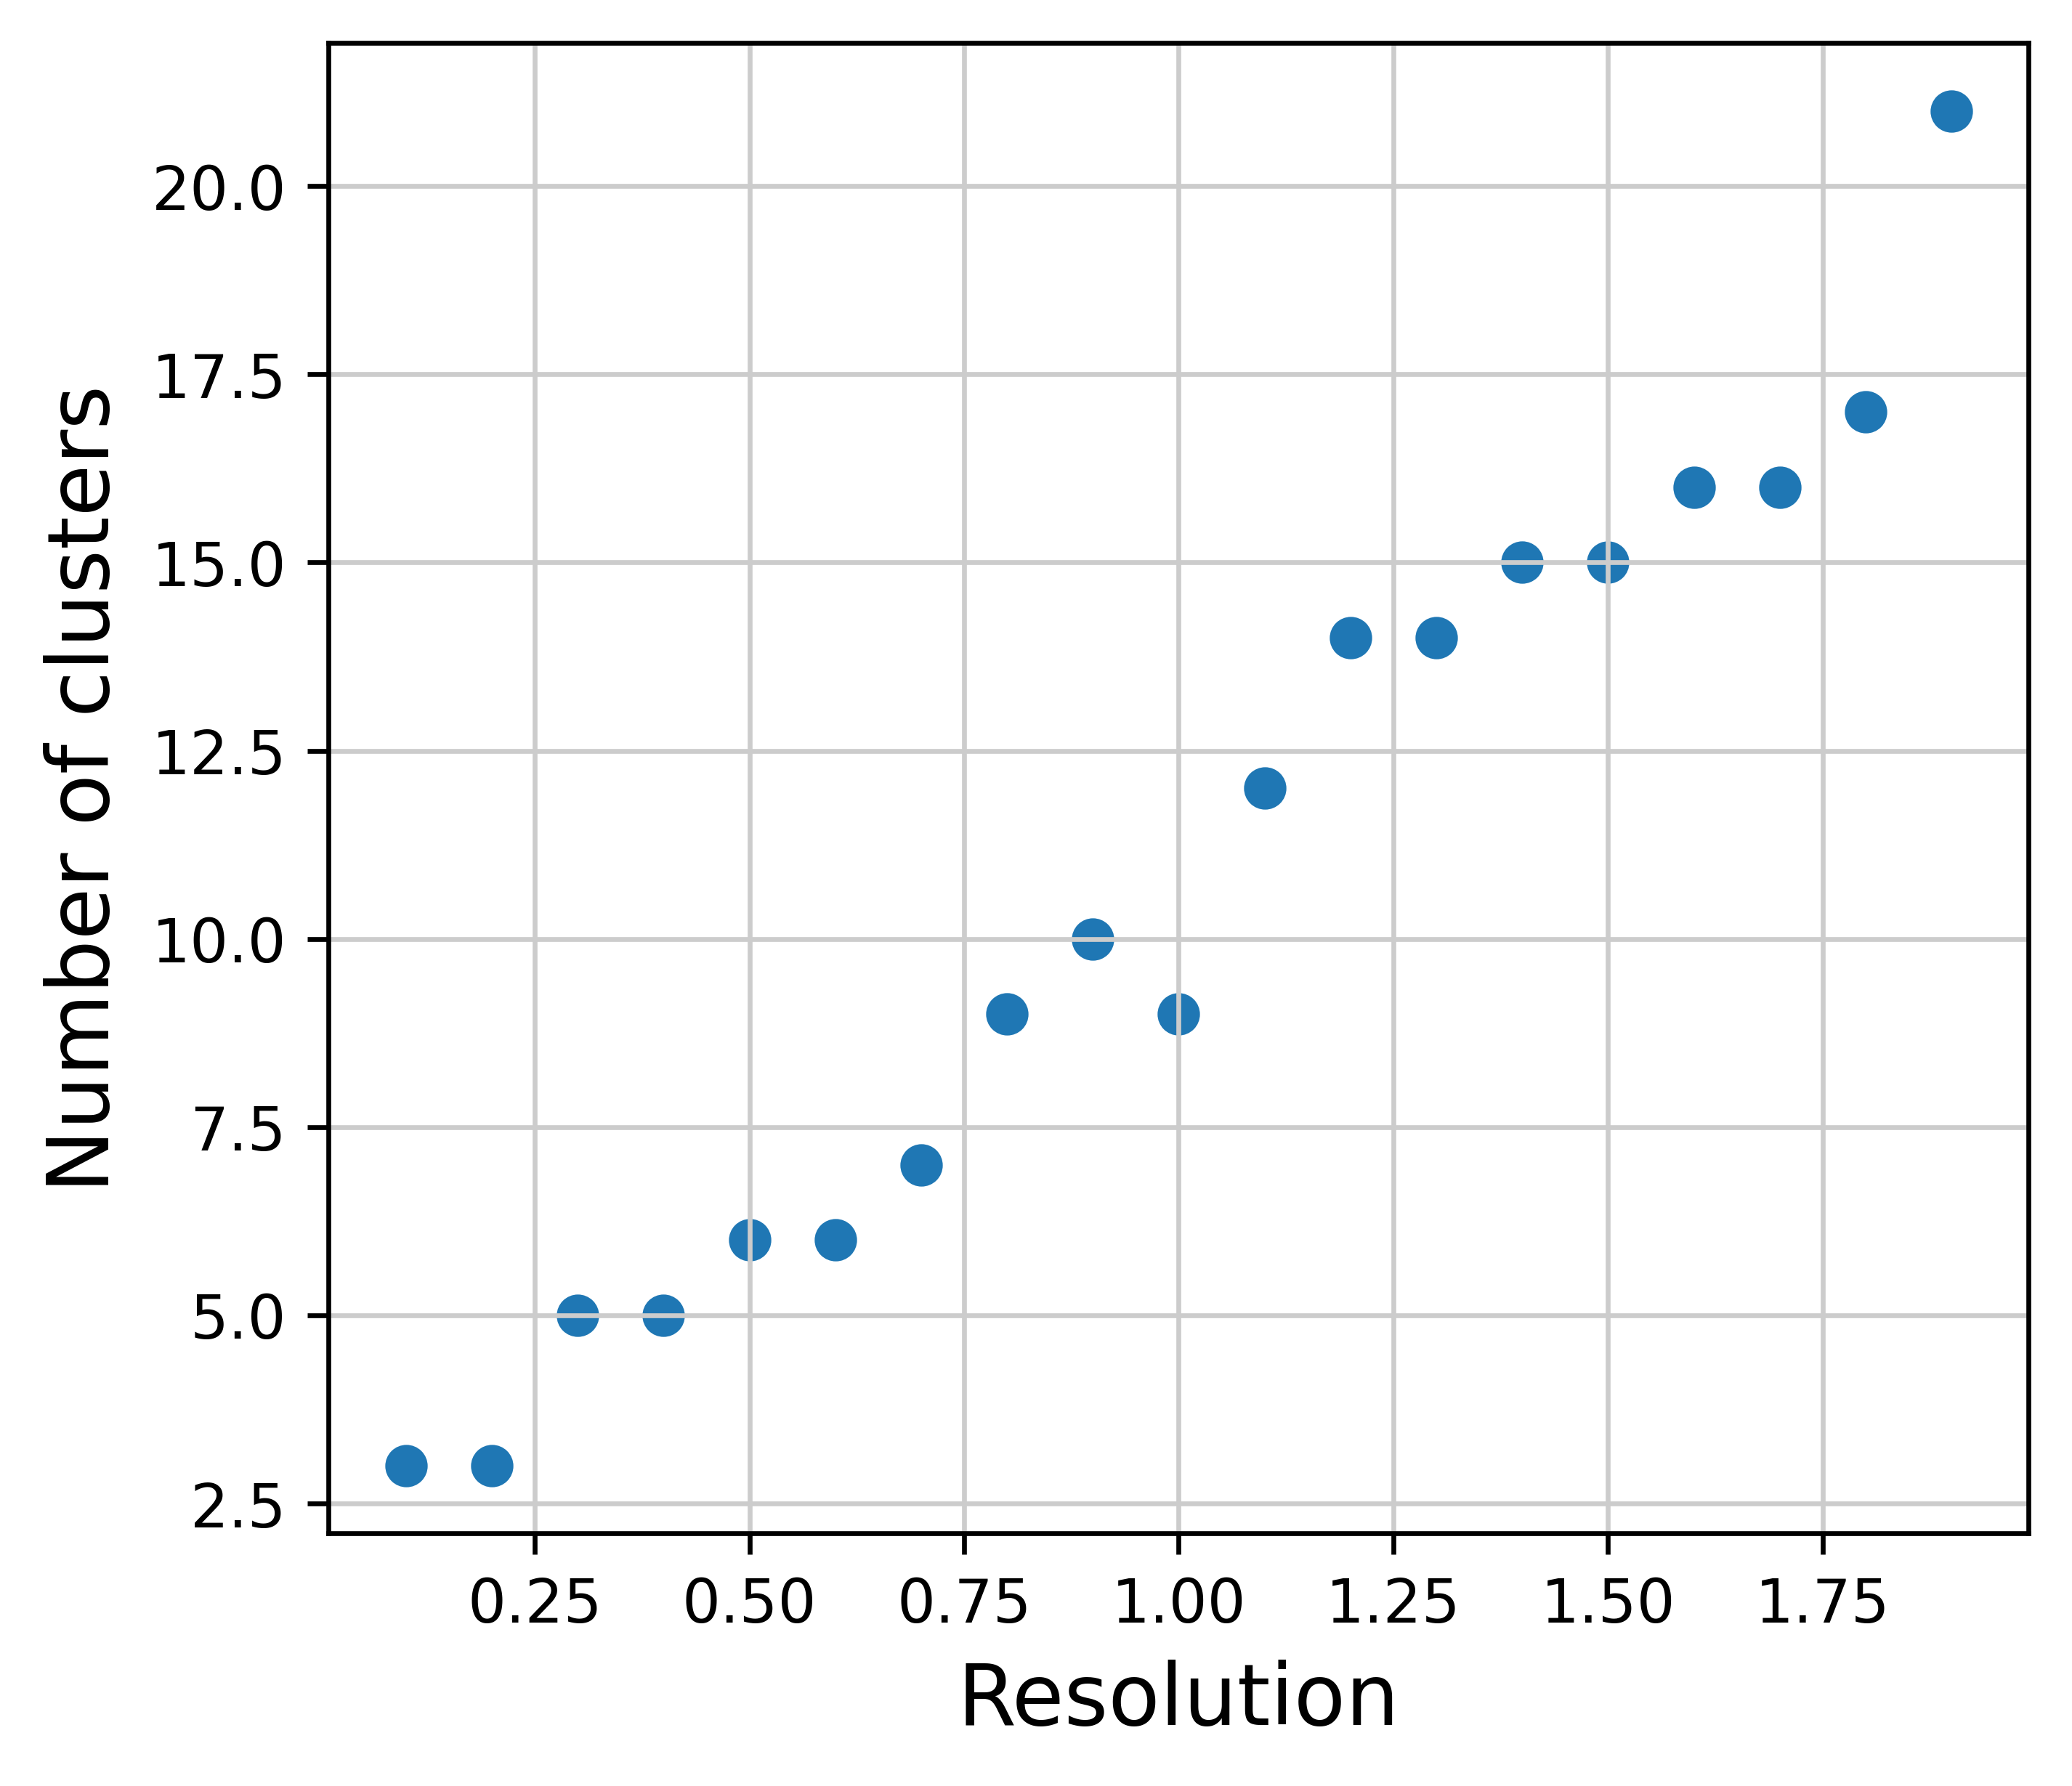

Frequency of NB clusters
Counter({3: 2, 5: 2, 6: 2, 9: 2, 14: 2, 15: 2, 16: 2, 7: 1, 10: 1, 12: 1, 17: 1, 21: 1})


In [10]:
clustering_leiden_resolution(adata, res_range=np.arange(0.1, 2, 0.1))

In [11]:
# neighbors were already computed using Harmony corrected PCs, so we perform clustering on that graph
sc.tl.leiden(adata, key_added="leiden_scVI_DC", resolution=0.3, random_state=7)

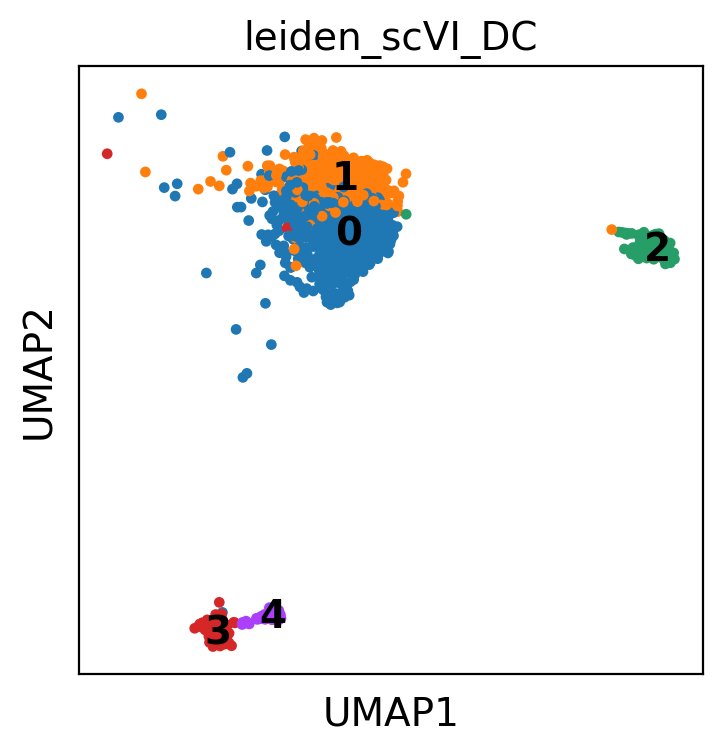

In [12]:
sc.pl.umap(
    adata,
    color="leiden_scVI_DC",
    legend_loc="on data",
    save="DC_clustering.pdf",
    show=True,
)

In [13]:
adata.obs.leiden_scVI_DC.value_counts()

0    965
1    578
2    239
3    163
4     72
Name: leiden_scVI_DC, dtype: int64

### Plot some markers

In [14]:
DC_markers = {
    "DC": ["FCER1A", "PKIB", "CD1C", "PCLAF", "CLEC10A"],
    "cDC1": ["CLEC9A", "XCR1", "BATF3", "RAB7B", "CADM1"],
    "cDC2": ["CD1C", "FCER1A", "CLEC10A", "MSLN", "JAML"],
    "DC3": ["CLEC10A", "S100A8", "CD36", "CD163"],
    "pDC": ["IL3RA", "LILRA4", "PLD4", "JCHAIN", "IL3RA", "SPIB", "MZB1", "IRF7"],
    "migDC": ["LAMP3", "CCR7", "FSCN1", "CCL19"],
}

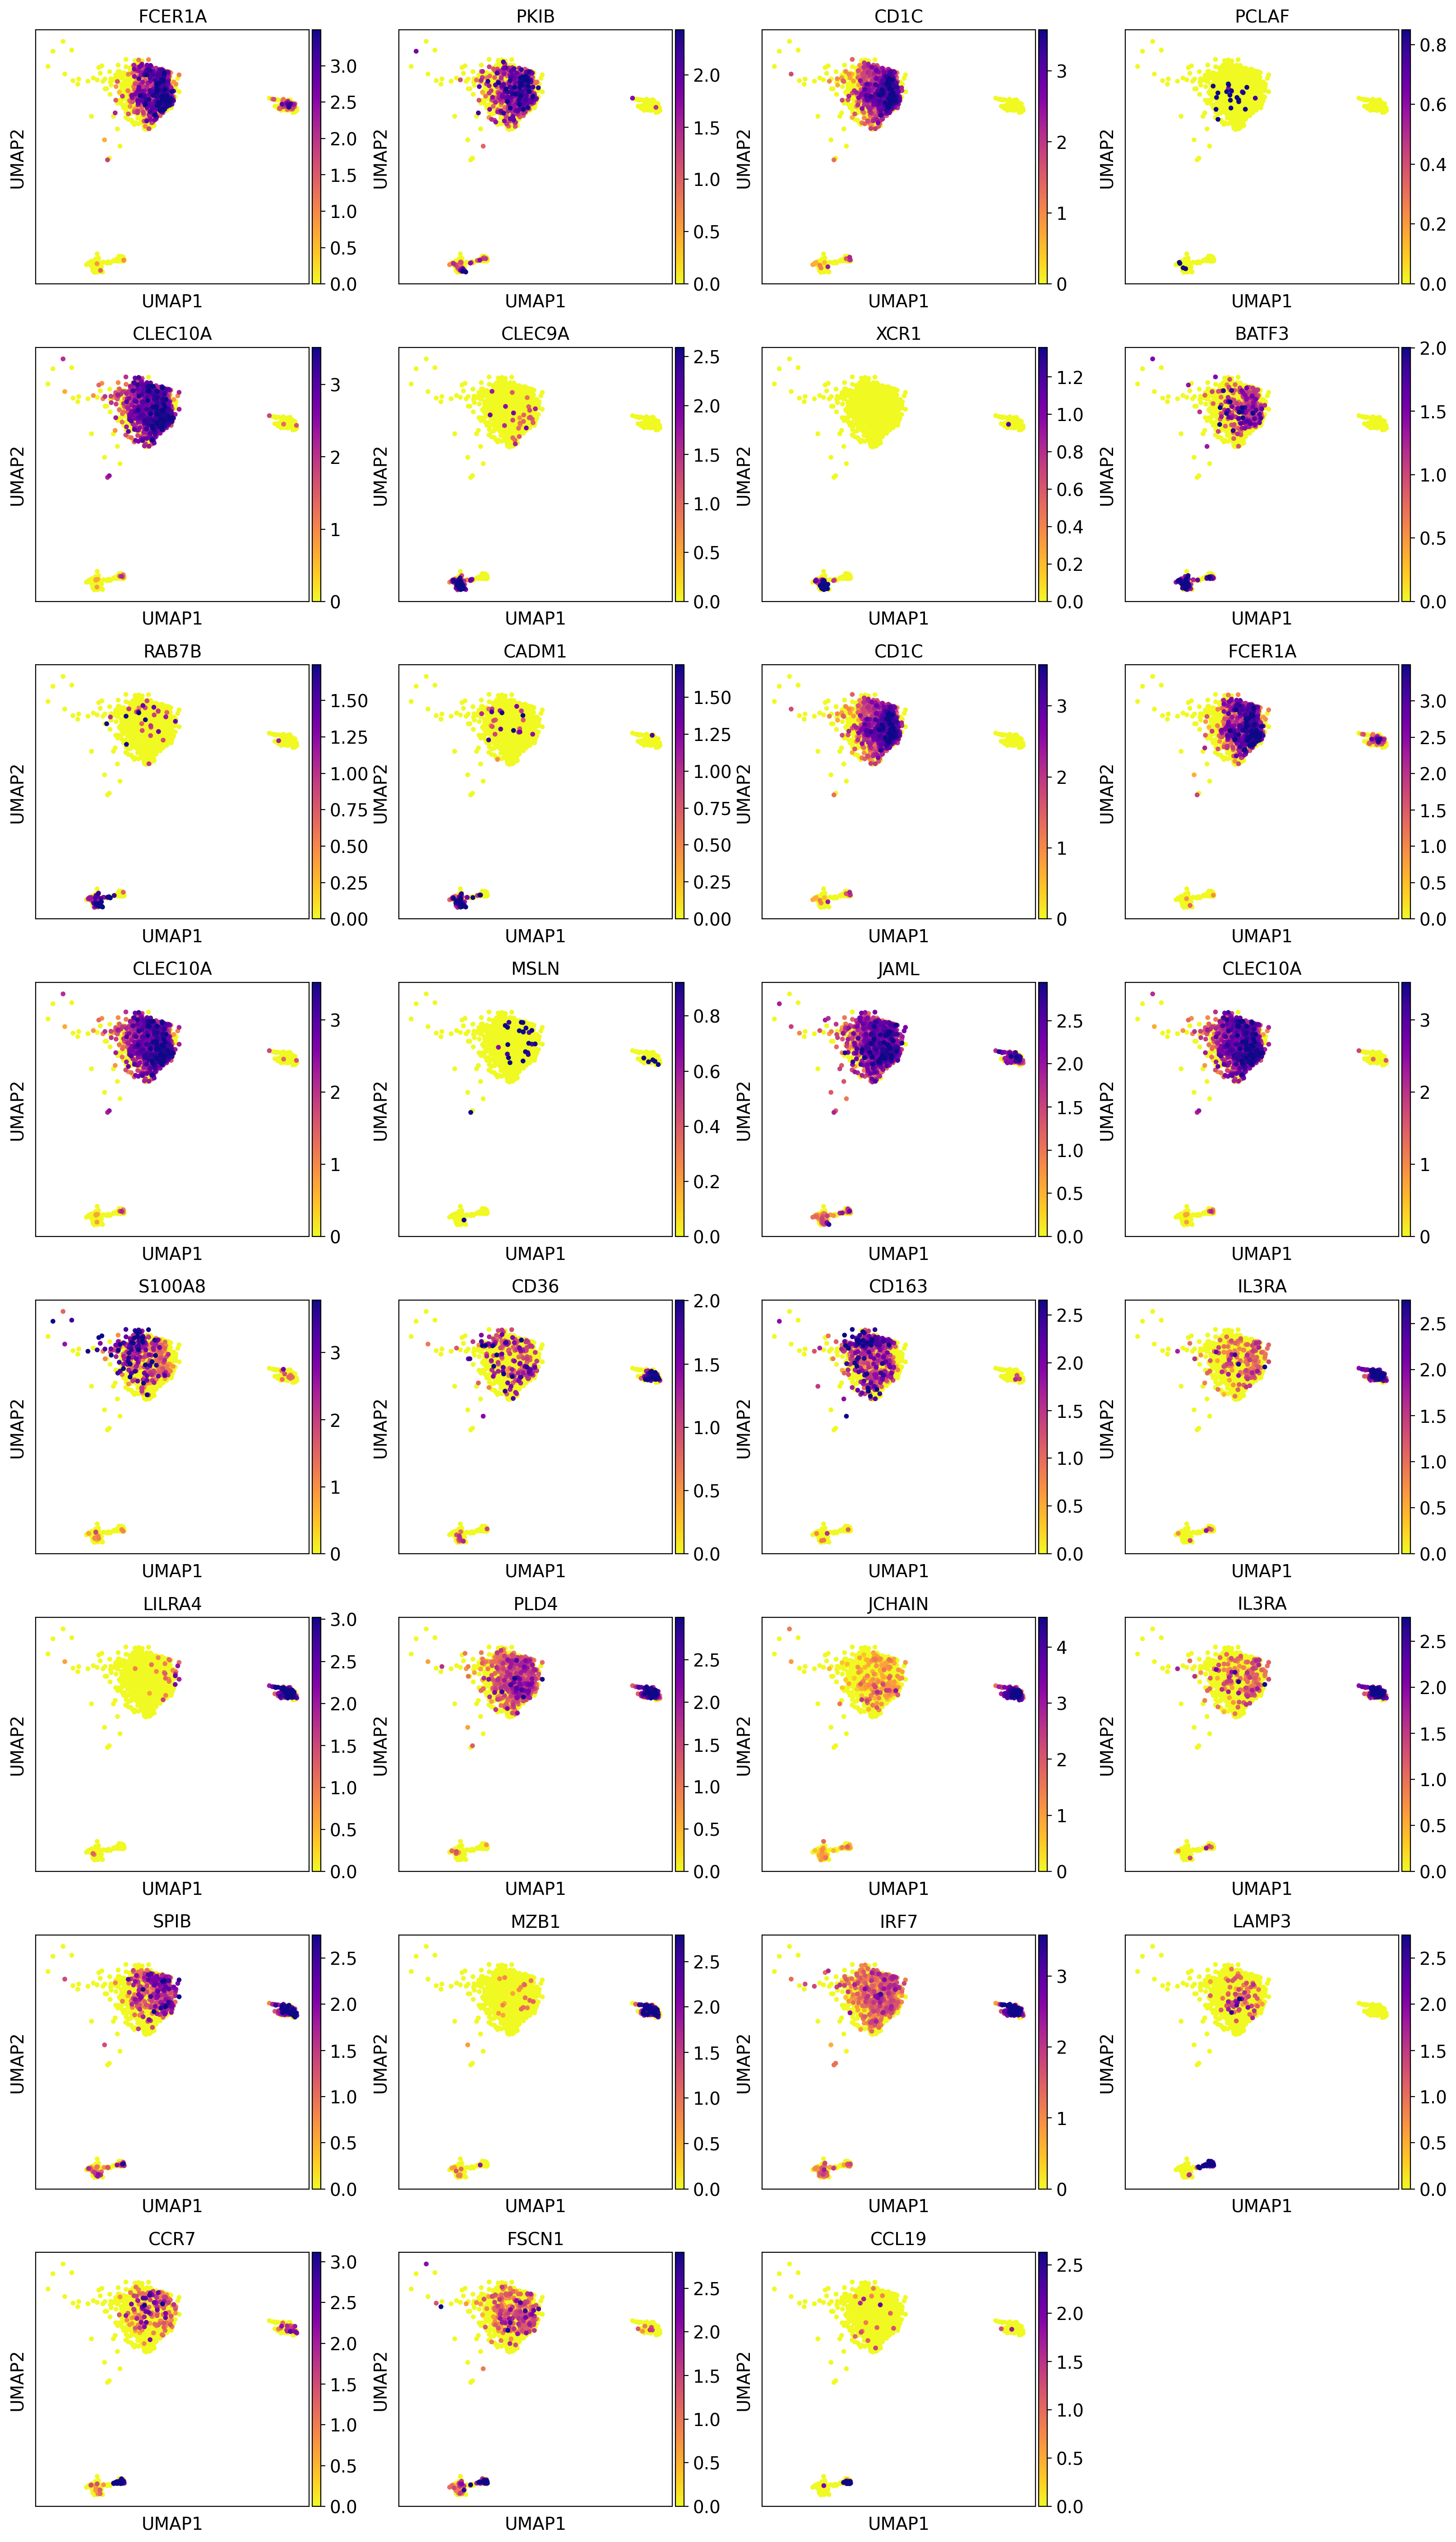

In [15]:
import itertools

# use log1p data stored in .raw
markers2plot = list(
    itertools.chain(*list(DC_markers.values()))
)  # get all markers in a single list
sc.pl.umap(
    adata,
    color=markers2plot,
    use_raw=True,
    vmin=0.0,
    vmax="p99",
    color_map="plasma_r",  #'RdPu',
    save="DCclustering_markers_DC.pdf",
    show=True,
)

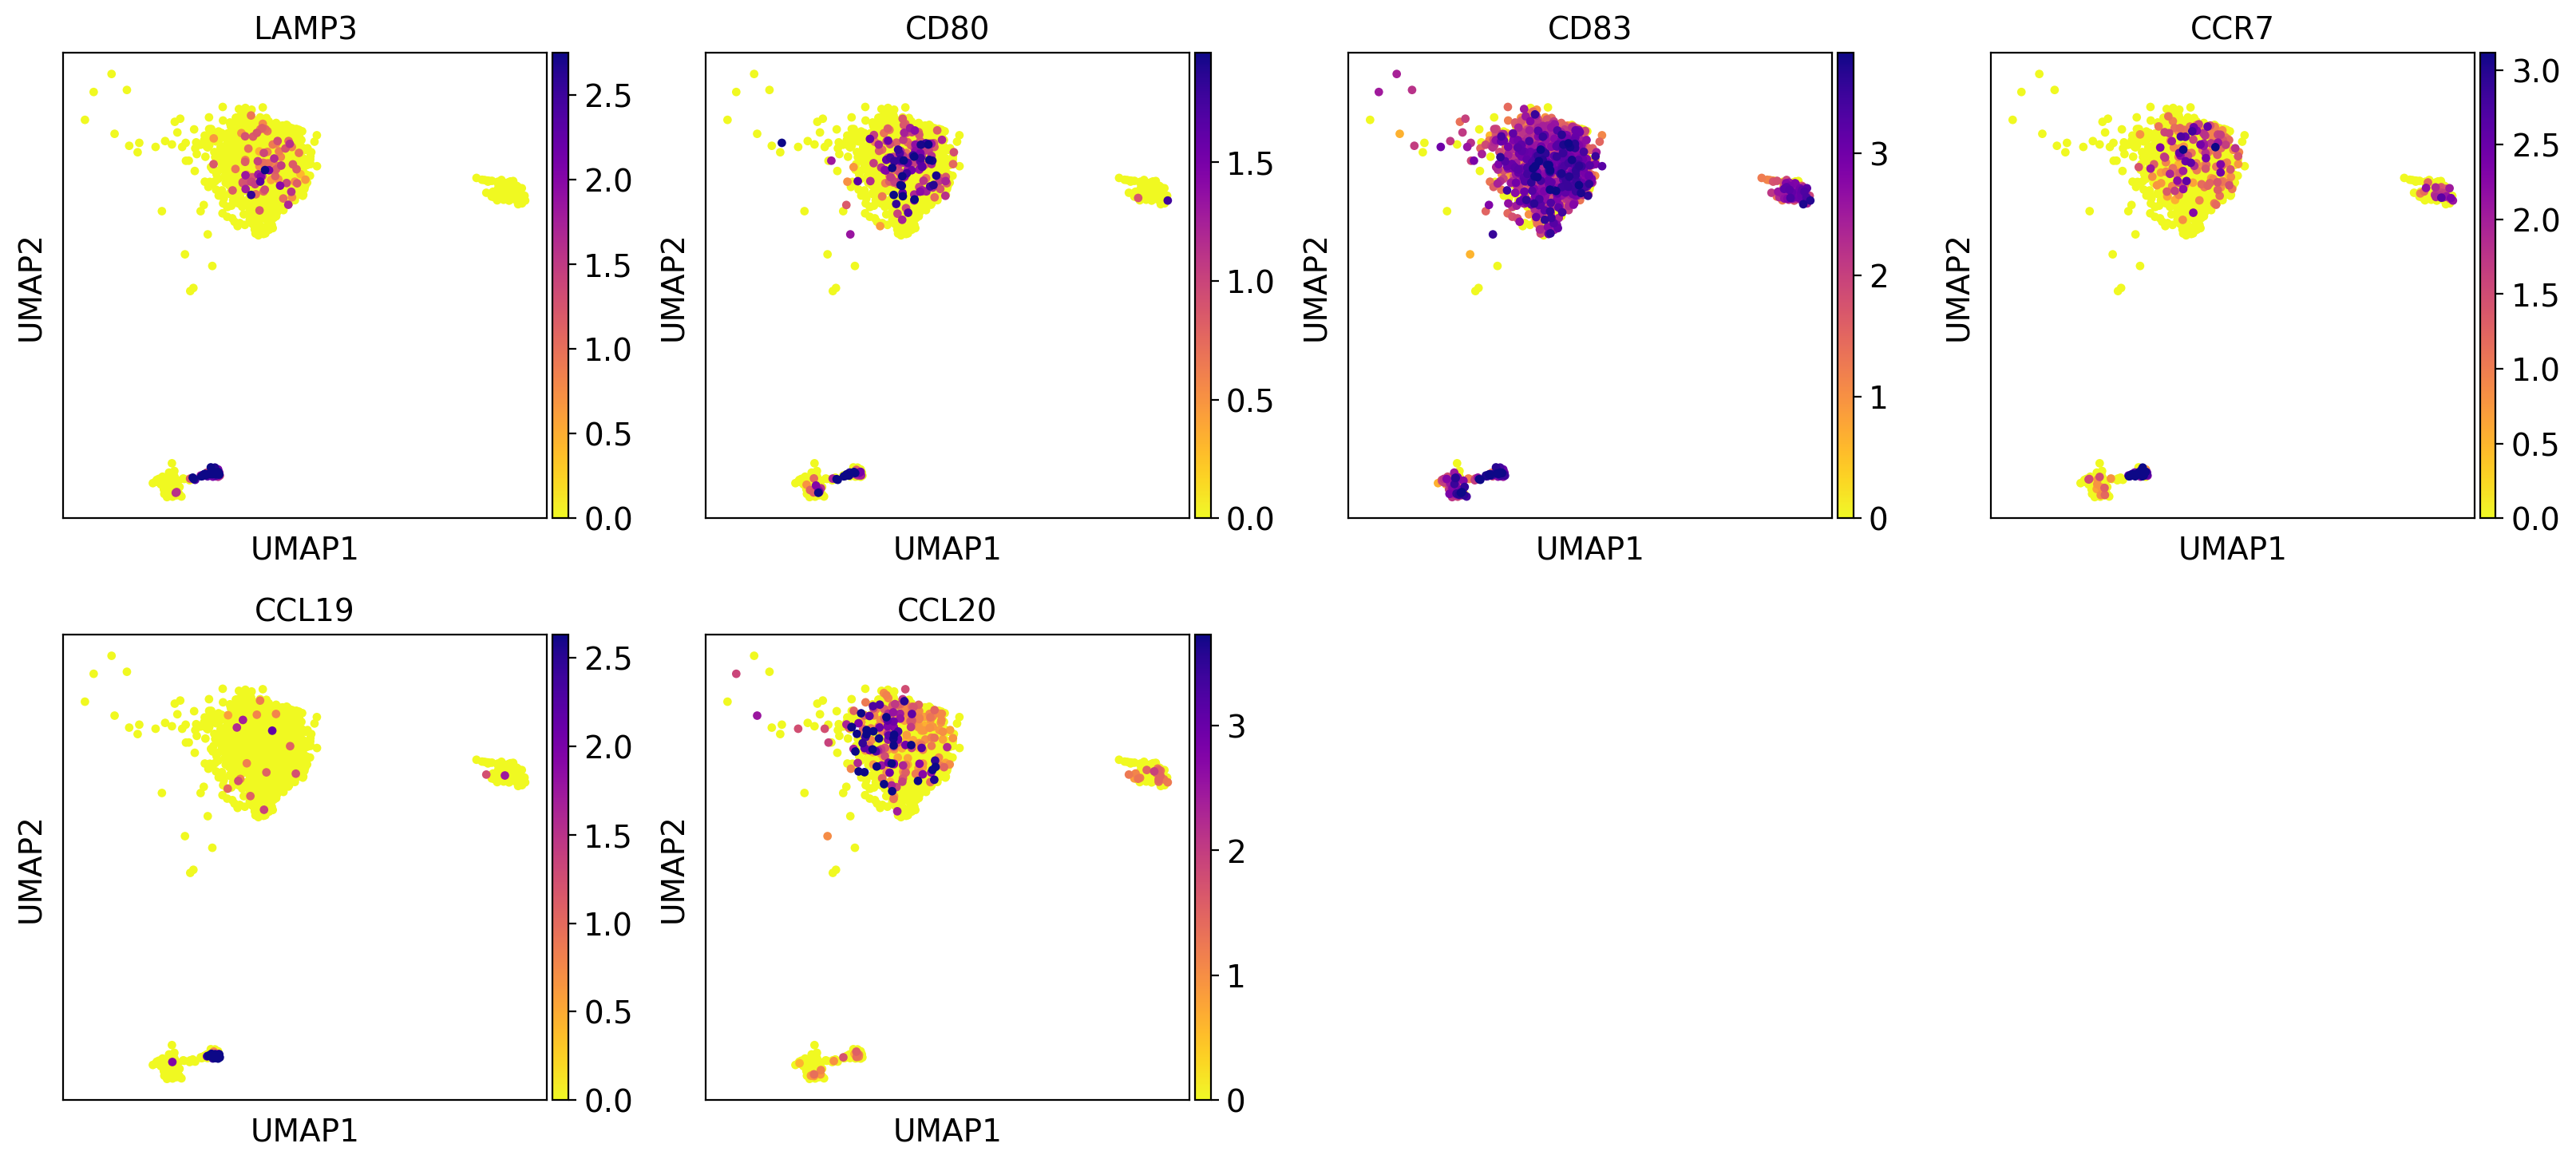

In [16]:
sc.pl.umap(
    adata,
    color=["LAMP3", "CD80", "CD83", "CCR7", "CCL19", "CCL20"],
    use_raw=True,
    vmin=0.0,
    vmax="p99",
    color_map="plasma_r",  #'RdPu',
    # save="DCclustering_markers_DC.pdf",
    show=True,
)

### Differential expression to get DE genes upregulated per cluster 

In [17]:
# issue here https://github.com/theislab/single-cell-tutorial/issues/97
# This seems to be a scanpy bug as you can see here and here. The latter issue suggests to just add the line:
# adata.uns['log1p']["base"] = None after reading again, or downgrading to AnnData<0.8.
# Either way, this should be fixed soon by the maintenance team.
adata.uns["log1p"]["base"] = None

In [18]:
sc.tl.rank_genes_groups(
    adata,
    groupby="leiden_scVI_DC",
    reference="rest",
    method="wilcoxon",
    use_raw=True,
    layer=None,
    pts=True,
    corr_method="benjamini-hochberg",
    key_added="rank_genes_wilcoxon",
)

categories: 0, 1, 2, etc.
var_group_labels: DC, cDC1, cDC2, etc.


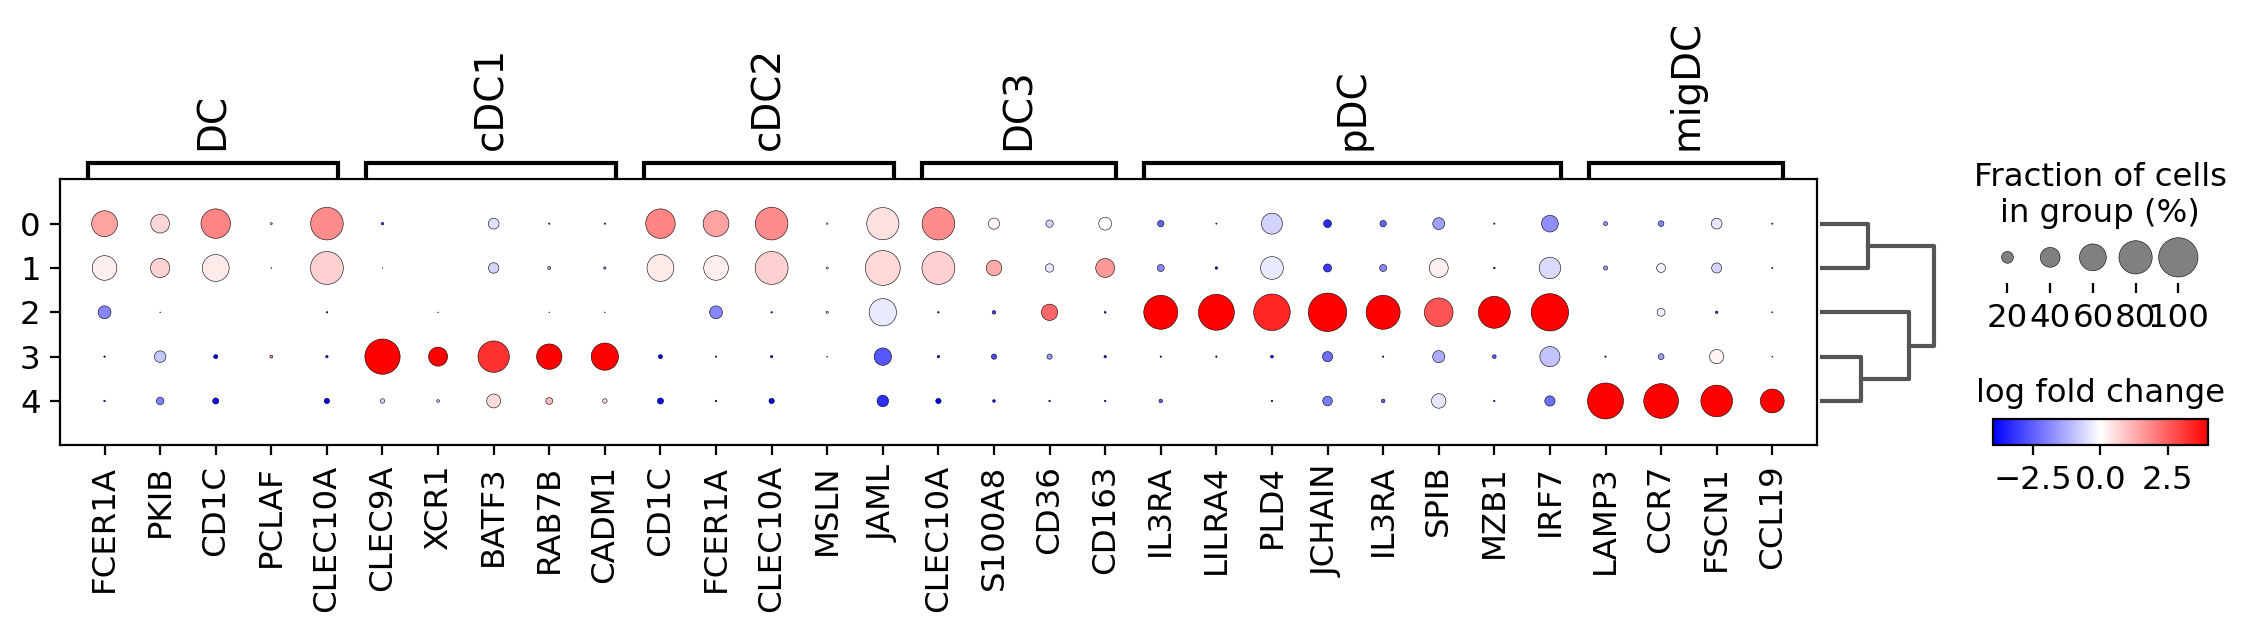

In [19]:
sc.pl.rank_genes_groups_dotplot(
    adata,
    groupby="leiden_scVI_DC",
    key="rank_genes_wilcoxon",
    var_names=DC_markers,
    values_to_plot="logfoldchanges",
    cmap="bwr",
    vmin=-4,
    vmax=4,
    min_logfoldchange=1,
    colorbar_title="log fold change",
    save="DCclustering_dotplot.pdf",
    show=True,
)

In [20]:
adata[adata.obs["cell_source"] == "BCI-Nuclei"].obs.leiden_scVI_DC.value_counts()

4    22
0    19
1    15
2     8
3     8
Name: leiden_scVI_DC, dtype: int64

In [21]:
adata[adata.obs["cell_source"] == "BCI-Nuclei"].obs[
    ["leiden_scVI_DC", "Cell_subtype"]
].value_counts()

leiden_scVI_DC  Cell_subtype 
4               No annotation    22
0               No annotation    19
1               No annotation    15
2               No annotation     8
3               No annotation     8
dtype: int64

In [22]:
adata.obs[["leiden_scVI_DC", "cell_source"]].groupby(
    ["leiden_scVI_DC", "cell_source"]
).size()

leiden_scVI_DC  cell_source
0               BCI-Nuclei      19
                Che-Cells      477
                Wu-Cells       469
1               BCI-Nuclei      15
                Che-Cells      388
                Wu-Cells       175
2               BCI-Nuclei       8
                Che-Cells      197
                Wu-Cells        34
3               BCI-Nuclei       8
                Che-Cells      108
                Wu-Cells        47
4               BCI-Nuclei      22
                Che-Cells       47
                Wu-Cells         3
dtype: int64

In [23]:
adata[adata.obs.cell_source == "BCI-Nuclei"].obs.Cell_subtype.value_counts()

No annotation    72
Name: Cell_subtype, dtype: int64

### Annotations

In [24]:
old_to_new = {"0": "cDC2", "1": "cDC2", "2": "pDC", "3": "cDC1", "4": "migDC"}

In [25]:
adata.obs["Annotation_scVI_detailed_DC"] = (
    adata.obs["leiden_scVI_DC"].map(old_to_new).astype("category")
)

### Change colours

In [26]:
# set colours for dataset, need to know order
adata.obs.Annotation_scVI_detailed_DC.cat.categories.values.tolist()

['cDC1', 'cDC2', 'migDC', 'pDC']

In [27]:
adata.uns["Annotation_scVI_detailed_DC_colors"] = [
    "#bc80bd",
    "#bebada",
    "#762a83",
    "#fa9fb5",
]

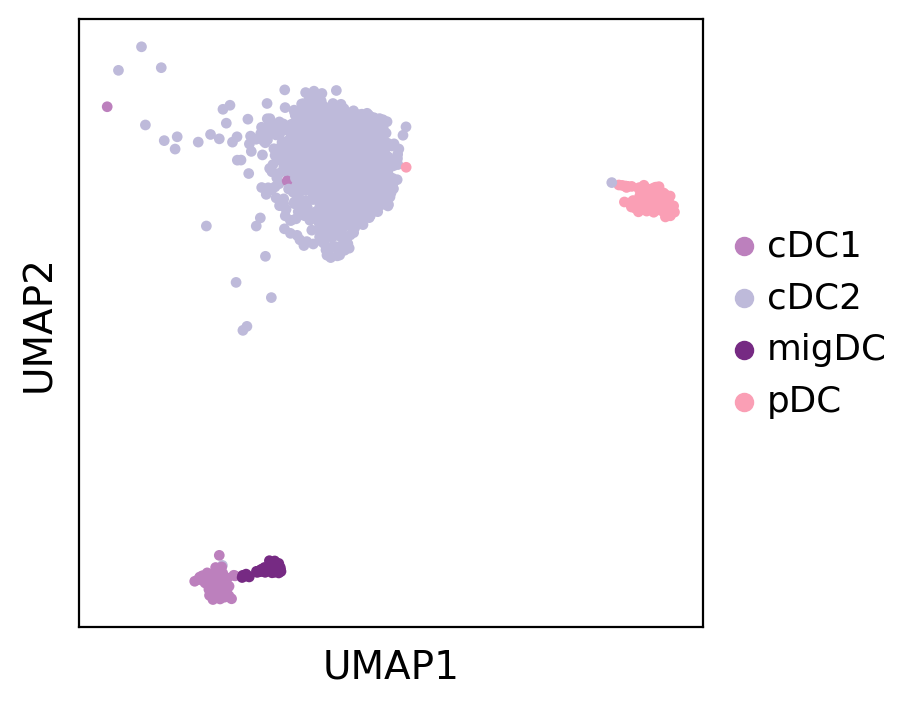

In [28]:
sc.pl.umap(
    adata,
    color="Annotation_scVI_detailed_DC",
    show=True,
    legend_loc="right margin",
    save="DC_annotations.pdf",
    title="",
)

In [30]:
# write to file
adata.write(
    DIR2SAVE.joinpath("Multiome_Che_Wu_CRC_LM_integrated_scvi_hvg_DC_clustering.h5ad")
)

In [31]:
adata.obs.Annotation_scVI_detailed_DC.value_counts()

cDC2     1543
pDC       239
cDC1      163
migDC      72
Name: Annotation_scVI_detailed_DC, dtype: int64